# Notebook for Exploratory Data Analysis
Notes:
 - Any general "to do" can go here

## Standard Loads for Uprooting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import awkward as ak

print('Numpy version: {}'.format(np.__version__))
print('Uproot version: {}'.format(ur.__version__))
print('Awkward version: {}'.format(ak.__version__))

Numpy version: 1.23.1
Uproot version: 4.3.3
Awkward version: 1.8.0


## Load Root Files and Make Histograms

### Files

In [2]:
rootfile_prefix = '/fast_scratch_1/atlas_images/XhhNTuple/'
rfile = 'user.zhenw.29137978._000001.MiniNTuple.root'

In [3]:
uprooted = ur.open(rootfile_prefix+rfile)
uprooted.keys()

['XhhMiniNtuple;1',
 'cutflow_XhhMiniNtuple;1',
 'cutflow_weighted_XhhMiniNtuple;1',
 'MetaData_EventCount_XhhMiniNtuple;1']

In [4]:
MNTuple = uprooted['XhhMiniNtuple']
# events.arrays(["px1", "py1", "pz1"])
MNTuple.show(name_width=32,
            interpretation_width=30)

name                             | typename                 | interpretation                
---------------------------------+--------------------------+-------------------------------
runNumber                        | int32_t                  | AsDtype('>i4')
eventNumber                      | int64_t                  | AsDtype('>i8')
lumiBlock                        | int32_t                  | AsDtype('>i4')
coreFlags                        | uint32_t                 | AsDtype('>u4')
bcid                             | int32_t                  | AsDtype('>i4')
mcEventNumber                    | int32_t                  | AsDtype('>i4')
mcChannelNumber                  | int32_t                  | AsDtype('>i4')
mcEventWeight                    | float                    | AsDtype('>f4')
NPV                              | int32_t                  | AsDtype('>i4')
actualInteractionsPerCrossing    | float                    | AsDtype('>f4')
averageInteractionsPerCrossing   | float    

## Inputs
boosted_nGoodJets
nboostedJets
boostedJets_m
boostedJets_pt
boostedJets_phi
boostedJets_eta


## Questions
boostedJets_Xbb2020v3_Higgs      | std::vector\<float>
boostedJets_Xbb2020v3_Top        | std::vector\<float>
boostedJets_Xbb2020v3_QCD        | std::vector\<float>
boostedJets_dRjj                 | std::vector\<float>
boostedJets_Split12              | std::vector\<float>
boostedJets_Split23              | std::vector\<float>
boostedJets_tau1_wta             | std::vector\<float>


## Targets
truth_mHH
truthjet_antikt10_pt
truthjet_antikt10_eta
truthjet_antikt10_phi
truthjet_antikt10_m

Notes: create histograms of delta R for jet matching
double check pt sorting
only choose first two jets

## Load utils

<M>

In [44]:
import os
import sys
cwd = os.getcwd()
path_head, path_tail = os.path.split(cwd)
sys.path.append(path_head+'/utils')
from ml_utils import dict_from_tree, DeltaR
from time import perf_counter as cput

In [6]:
branches = ['boosted_nGoodJets', "nboostedJets", "boostedJets_m",
            "boostedJets_pt", "boostedJets_phi", "boostedJets_eta",
           "truth_mHH", 'truthjet_antikt10_pt', 'truthjet_antikt10_eta',
           'truthjet_antikt10_phi', 'truthjet_antikt10_m']
np_branches = ['eventNumber']

In [7]:
# hh4b_dict = dict_from_tree(MNTuple, branches, np_branches)

In [18]:
t0 = cput()
hh4b_dict = dict_from_tree(MNTuple, branches, np_branches)
t1 = cput()
method_1_time = t1 - t0
print('Time to load arrays: {:8.4f} (s)'.format(method_1_time))

nEvents = len(hh4b_dict['eventNumber'])
print('{} Events'.format(nEvents))

Time to load arrays:   1.0542 (s)
339978 Events


## Check for pt ordering of jets

In [36]:
ordered_jets = np.zeros(nEvents, dtype=bool)
nBoostedJets = np.empty(nEvents, dtype=int)
gt_twoJets = np.zeros(nEvents, dtype=bool)

t0 = cput()
for i in range(nEvents):
    boostedJets_pt = ak.to_numpy(hh4b_dict['boostedJets_pt'][i])
    
    nBoostedJets[i] = len(boostedJets_pt)
    ordered_jets[i] = np.all(boostedJets_pt[:-1] >= boostedJets_pt[1:])
    
    if nBoostedJets[i] >=2:
        gt_twoJets[i] = True
    
if np.any(np.invert(ordered_jets)):
    print('Found Jets that are not ordered!!')
else:
    print('Jets are ordered with respect to pt')
t1 = cput()

print('Number of events with two or more boosted jets: {}'.format(
    np.count_nonzero(gt_twoJets)))

Jets are ordered with respect to pt
Number of events with two or more boosted jets: 95892


## Find number of boosted jets!

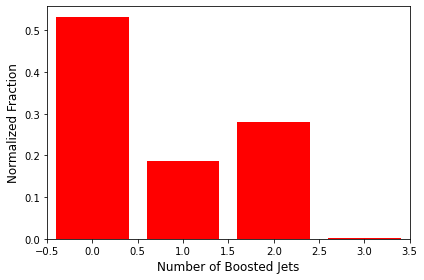

In [35]:
bin_edges = np.arange(-.5, 4.5, 1)

plt.hist(nBoostedJets, bins=bin_edges, density=True, rwidth=.8, color='red')
plt.xlim(np.min(bin_edges), np.max(bin_edges))
# plt.title('Number of boosted Jets', fontsize=14)
plt.ylabel('Normalized Fraction', fontsize=12)
plt.xlabel('Number of Boosted Jets', fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/Summer22/MNT_NumberBoostedJets.png', format='png')
plt.show()

In [46]:
evt_idx = np.arange(nEvents)[gt_twoJets]
matched_jets = np.zeros(len(gt_twoJets), dtype=bool)

LeadingJet_DR = np.empty(len(gt_twoJets))
subLeadingJet_DR = np.empty(len(gt_twoJets))

In [47]:
np.set_printoptions(precision=2)

In [59]:
matched_jets = []

t0 = cput()
for i, evt in enumerate(evt_idx):
    
    nTruthJets = ak.to_numpy(hh4b_dict['truthjet_antikt10_m'][evt]).shape[0]
    truthJet_coords = np.empty((nTruthJets, 2))
    for j in range(nTruthJets):
        truthJet_coords[j,0] = hh4b_dict['truthjet_antikt10_eta'][evt][j]
        truthJet_coords[j,1] = hh4b_dict['truthjet_antikt10_phi'][evt][j]

    # print(truthJet_coords)
    
    BoostedJet0_eta = hh4b_dict['boostedJets_eta'][evt][0]
    BoostedJet0_phi = hh4b_dict['boostedJets_phi'][evt][0]
    BoostedJet0_coords = np.array([BoostedJet0_eta, BoostedJet0_phi])
    LeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet0_coords)
    # print(LeadingJet_DR_arr)
    LJ_DR = np.min(LeadingJet_DR_arr)
    LJ_DR_idx = np.argmin(LeadingJet_DR_arr)
    LeadingJet_DR[i] = LJ_DR
    
    BoostedJet1_eta = hh4b_dict['boostedJets_eta'][evt][1]
    BoostedJet1_phi = hh4b_dict['boostedJets_phi'][evt][1]
    BoostedJet1_coords = np.array([BoostedJet1_eta, BoostedJet1_phi])
    subLeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet1_coords)
    # print(subLeadingJet_DR_arr)
    SLJ_DR = np.min(subLeadingJet_DR_arr)
    SLJ_DR_idx = np.argmin(subLeadingJet_DR_arr)
    subLeadingJet_DR[i] = SLJ_DR
    
    if SLJ_DR_idx != LJ_DR_idx:
        if LJ_DR < .1 and SLJ_DR < .1:
            matched_jets.append([LJ_DR_idx, SLJ_DR_idx])
    
    # print();print()

t1 = cput()
print('Time to complete jet matching: {:6.3f} (m)'.format((t1 - t0)/60))
print();print()
matched_jets = np.array(matched_jets)
for i in range(20):
    print(matched_jets[i])

Time to complete jet matching:  1.623 (m)


[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]


## Plot $\Delta R$ for Leading and sub-Leading Jets

### Leading Jet

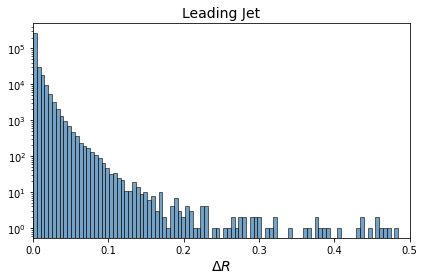

In [70]:
DR_bins = np.linspace(0,.5,100,endpoint=True)
plt.hist(LeadingJet_DR, bins=DR_bins, color='steelblue',
         alpha=.75, linewidth=.75, edgecolor='black')
plt.yscale('log')
plt.xlim(0,.5)
plt.title('Leading Jet', fontsize=14)
plt.xlabel('$\Delta R$', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/Summer22/MNT_LeadingJet_DR.png', format='png')
plt.show()

### Sub-Leading Jet

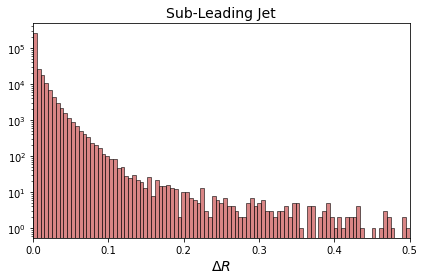

In [71]:
DR_bins = np.linspace(0,.5,100,endpoint=True)
plt.hist(subLeadingJet_DR, bins=DR_bins, color='indianred',
         alpha=.75, linewidth=.75, edgecolor='black')
plt.yscale('log')
plt.xlim(0,.5)
plt.title('Sub-Leading Jet', fontsize=14)
plt.xlabel('$\Delta R$', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/Summer22/MNT_SubLeadingJet_DR.png', format='png')
plt.show()

### Combined

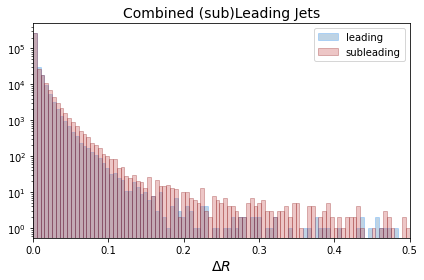

In [74]:
DR_bins = np.linspace(0,.5,100,endpoint=True)
plt.hist(LeadingJet_DR, bins=DR_bins, color='steelblue',
         alpha=.35, linewidth=.75, edgecolor='dodgerblue', label='leading')
plt.hist(subLeadingJet_DR, bins=DR_bins, color='indianred',
         alpha=.35, linewidth=.75, edgecolor='maroon', label='subleading')
plt.yscale('log')
plt.xlim(0,.5)
plt.title('Combined (sub)Leading Jets', fontsize=14)
plt.xlabel('$\Delta R$', fontsize=14)
plt.legend()
# plt.tight_layout()
# plt.savefig('Plots/Summer22/MNT_Combined_Jet_DR.png', format='png')
plt.show()